## X-Ray Abnormality Detection | CNN

> **Giogiakas Sotirios** ( *p3352204* ) <br />
> **Sakkis Panagiotis** ( *p3352222* ) <br />
> **MSc in Data Science, AUEB**

In [1]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from enum import Enum
from tensorflow.keras import backend as K
import gc

from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
#from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50




pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

c:\Users\sotir\anaconda3\envs\myenv4\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\sotir\anaconda3\envs\myenv4\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
print(tf.__version__)

2.10.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)




def plot_all_metrics(history):
    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    # Limit the metrics to the first 4
    metrics = metrics[:4] 
    num_metrics = len(metrics)
    
    num_rows = (num_metrics + 1) // 2
    num_cols = 2  
    
    plt.figure(figsize=(12, 4 * num_rows))
    
    for i, metric in enumerate(metrics):
        row_idx = i // num_cols  # Calculate the row index
        col_idx = i % num_cols   # Calculate the column index
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(history.epoch, history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.epoch, history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.legend()        

### Preprocess

In [7]:
DATASET_DIR = "../Assignment 2/MURA-v1.1/"

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [8]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../Assignment 2/MURA-v1.1/>: 40009


We load the data and check their shape.

In [9]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [10]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../Assignment 2/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [11]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [12]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [13]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../Assignment 2/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [14]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [15]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [16]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [17]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

#### CNN architecture with all study types

We set some metrics definition to check the metrics during training!

In [19]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="cohen_kappa", num_classes=2),
        F1Score(name="f1_score")
    ]

In [20]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [21]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc", curve="ROC"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
    F1Score(name="f1_score")
]

In [22]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                activation="relu",
                name="1st-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="1st-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            # tf.keras.layers.Dropout(
            #     rate=0.2,
            #     name="1st-dropout",
            # ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                # kernel_regularizer="l2",
                # dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="2nd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            # tf.keras.layers.Dropout(
            #     rate=0.2,
            #     name="2nd-dropout",
            # ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                activation="relu",
                name="3rd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="3rd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="3rd-max-pooling"
            ),
            # tf.keras.layers.Dropout(
            #     rate=0.2,
            #     name="3rd-dropout",
            # ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                activation="relu",
                name="4th-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="4th-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="4th-max-pooling"
            ),
            # tf.keras.layers.Dropout(
            #     rate=0.1,
            #     name="4th-dropout",
            # ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )


    model.compile(optimizer=Adam(learning_rate=0.0001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])

    return model

In [23]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=128,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [24]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=128,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


In [25]:
model = make_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 16)      448       
                                                                 
 1st-batch-norm (BatchNormal  (None, 224, 224, 16)     64        
 ization)                                                        
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 64)      9280      
                                                                 
 2nd-batch-norm (BatchNormal  (None, 112, 112, 64)     256       
 ization)                                                        
                                                        

In [26]:
early_stopping = EarlyStopping(monitor="val_loss",mode="min", patience=3,restore_best_weights=True)

In [27]:
history = model.fit(
    trainset,
    epochs=20,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/20
231/231 [==============================] - 824s 4s/step - loss: 0.6754 - auc: 0.5986 - accuracy: 0.5971 - cohen_kappa: 0.0663 - f1_score: 0.2593 - val_loss: 0.6898 - val_auc: 0.5235 - val_accuracy: 0.5555 - val_cohen_kappa: 0.0277 - val_f1_score: 0.3523
Epoch 2/20
231/231 [==============================] - 467s 2s/step - loss: 0.6372 - auc: 0.6556 - accuracy: 0.6277 - cohen_kappa: 0.1634 - f1_score: 0.3948 - val_loss: 0.7131 - val_auc: 0.5184 - val_accuracy: 0.5866 - val_cohen_kappa: 0.0366 - val_f1_score: 0.2432
Epoch 3/20
231/231 [==============================] - 466s 2s/step - loss: 0.6203 - auc: 0.6849 - accuracy: 0.6490 - cohen_kappa: 0.2275 - f1_score: 0.4717 - val_loss: 0.6745 - val_auc: 0.6216 - val_accuracy: 0.6187 - val_cohen_kappa: 0.0819 - val_f1_score: 0.2019
Epoch 4/20
231/231 [==============================] - 463s 2s/step - loss: 0.6084 - auc: 0.7032 - accuracy: 0.6631 - cohen_kappa: 0.2658 - f1_score: 0.5106 - val_loss: 0.6054 - val_auc: 0.7068 - val_accura

In [28]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

58/58 [==============================] - 82s 1s/step - loss: 0.5522 - auc: 0.7698 - accuracy: 0.7090 - cohen_kappa: 0.3866 - f1_score: 0.6230


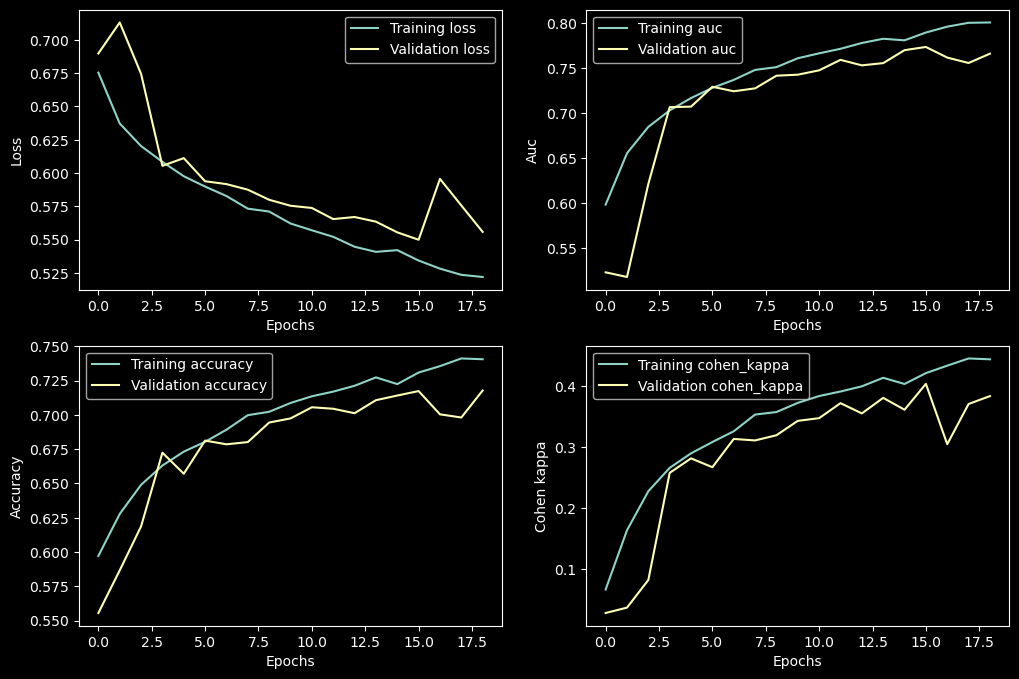

In [29]:
plot_all_metrics(history)


In [30]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.5521751046180725
accuracy    : 0.769812285900116
auc         : 0.7090069055557251
cohen_kappa : 0.38656049966812134
f1_score    : 0.6230200529098511


#### XR_SHOULDER

In [31]:
model_shoulder = make_cnn_model()

In [32]:
early_stopping = EarlyStopping(monitor="val_loss",mode="min", patience=3,restore_best_weights=True)

In [33]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6704 validated image filenames belonging to 2 classes.


In [34]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1675 validated image filenames belonging to 2 classes.


In [35]:
history = model_shoulder.fit(
    trainset,
    epochs=50,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/50
210/210 [==============================] - 101s 473ms/step - loss: 0.7220 - auc: 0.5566 - accuracy: 0.5428 - cohen_kappa: 0.0855 - f1_score: 0.5087 - val_loss: 1.0624 - val_auc: 0.5398 - val_accuracy: 0.4901 - val_cohen_kappa: 0.0033 - val_f1_score: 0.6565
Epoch 2/50
210/210 [==============================] - 104s 496ms/step - loss: 0.6605 - auc: 0.6565 - accuracy: 0.6193 - cohen_kappa: 0.2386 - f1_score: 0.5987 - val_loss: 0.7497 - val_auc: 0.5771 - val_accuracy: 0.5690 - val_cohen_kappa: 0.1354 - val_f1_score: 0.5348
Epoch 3/50
210/210 [==============================] - 102s 486ms/step - loss: 0.6314 - auc: 0.6934 - accuracy: 0.6402 - cohen_kappa: 0.2804 - f1_score: 0.6242 - val_loss: 0.6425 - val_auc: 0.6688 - val_accuracy: 0.6245 - val_cohen_kappa: 0.2442 - val_f1_score: 0.5592
Epoch 4/50
210/210 [==============================] - 102s 483ms/step - loss: 0.6149 - auc: 0.7169 - accuracy: 0.6587 - cohen_kappa: 0.3174 - f1_score: 0.6412 - val_loss: 0.6313 - val_auc: 0.6976 

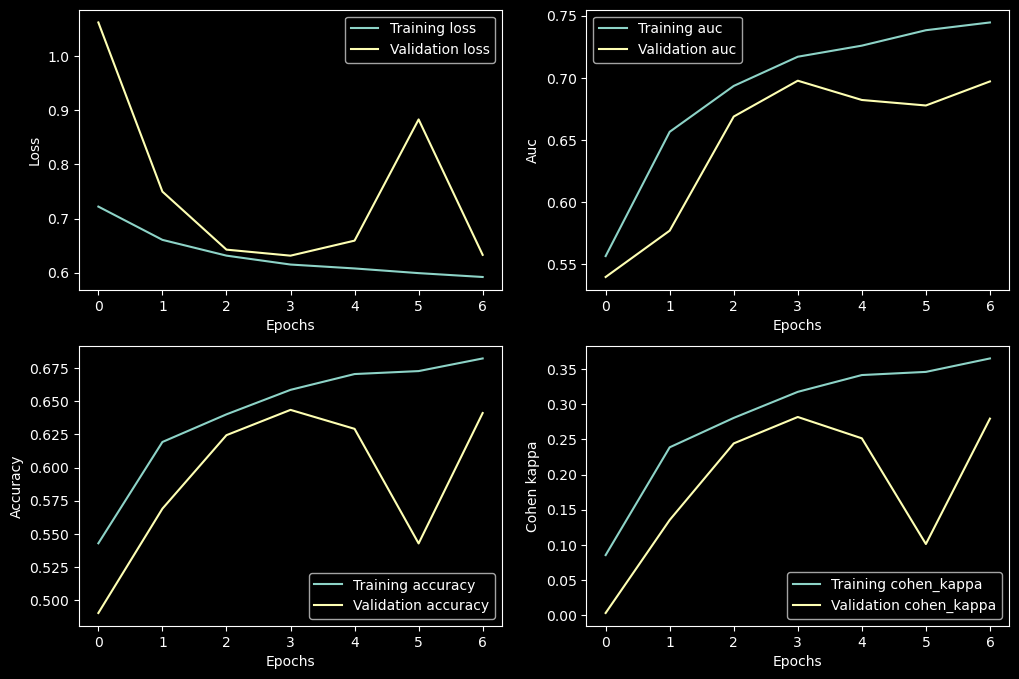

In [36]:
plot_all_metrics(history)


In [37]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_shoulder.evaluate(validationset, verbose=1)

53/53 [==============================] - 20s 378ms/step - loss: 0.6297 - auc: 0.6973 - accuracy: 0.6388 - cohen_kappa: 0.2718 - f1_score: 0.5574


In [38]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6296815872192383
accuracy    : 0.6972751617431641
auc         : 0.6388059854507446
cohen_kappa : 0.2717711329460144
f1_score    : 0.5574250221252441


#### XR_ELBOW

In [39]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 3945 validated image filenames belonging to 2 classes.


In [40]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 986 validated image filenames belonging to 2 classes.


In [41]:
model_elbow = make_cnn_model()

In [42]:
history = model_elbow.fit(
    trainset,
    epochs=50,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/50
124/124 [==============================] - 61s 481ms/step - loss: 0.7072 - auc: 0.5842 - accuracy: 0.5937 - cohen_kappa: 0.1072 - f1_score: 0.3907 - val_loss: 1.0187 - val_auc: 0.5792 - val_accuracy: 0.4097 - val_cohen_kappa: 0.0014 - val_f1_score: 0.5807
Epoch 2/50
124/124 [==============================] - 62s 503ms/step - loss: 0.6527 - auc: 0.6291 - accuracy: 0.6185 - cohen_kappa: 0.1592 - f1_score: 0.4214 - val_loss: 1.3911 - val_auc: 0.5918 - val_accuracy: 0.4178 - val_cohen_kappa: 0.0095 - val_f1_score: 0.5810
Epoch 3/50
124/124 [==============================] - 59s 477ms/step - loss: 0.6421 - auc: 0.6482 - accuracy: 0.6228 - cohen_kappa: 0.1813 - f1_score: 0.4585 - val_loss: 0.6845 - val_auc: 0.6399 - val_accuracy: 0.5923 - val_cohen_kappa: 0.1882 - val_f1_score: 0.5573
Epoch 4/50
124/124 [==============================] - 58s 464ms/step - loss: 0.6331 - auc: 0.6665 - accuracy: 0.6365 - cohen_kappa: 0.2029 - f1_score: 0.4589 - val_loss: 0.6406 - val_auc: 0.6680 - va

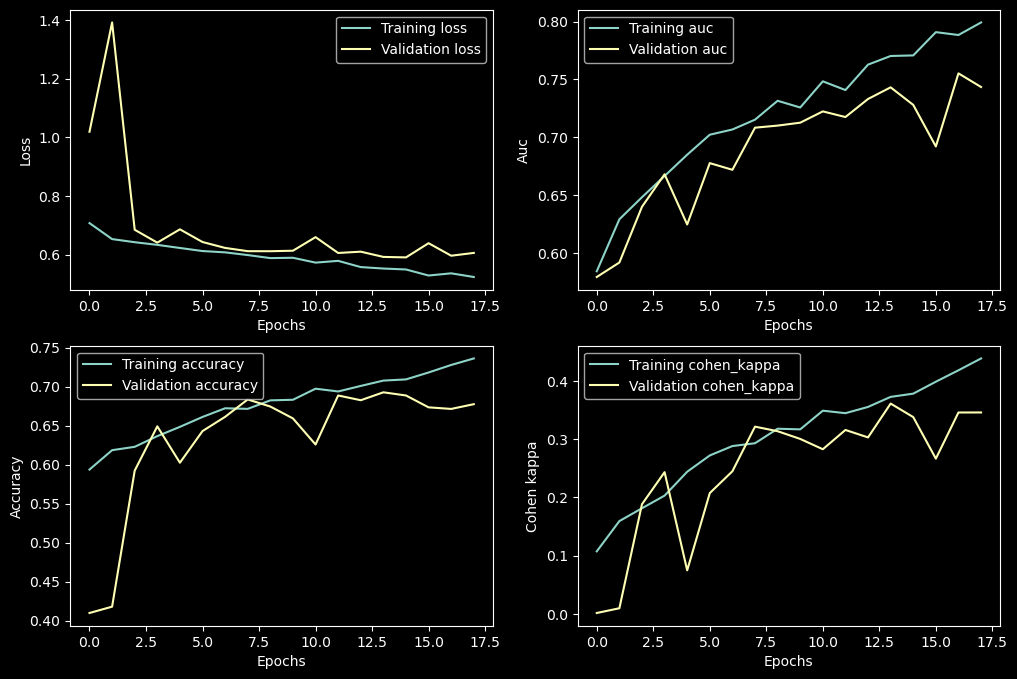

In [43]:
plot_all_metrics(history)

In [44]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_elbow.evaluate(validationset, verbose=1)

31/31 [==============================] - 12s 370ms/step - loss: 0.5676 - auc: 0.7503 - accuracy: 0.6897 - cohen_kappa: 0.3423 - f1_score: 0.5887


In [45]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.567646324634552
accuracy    : 0.7503394484519958
auc         : 0.6896551847457886
cohen_kappa : 0.3422912359237671
f1_score    : 0.5887096524238586


#### XR_HUMERUS

In [46]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=8,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1018 validated image filenames belonging to 2 classes.


In [47]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=8,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 254 validated image filenames belonging to 2 classes.


In [48]:
model_humerus = make_cnn_model()

In [49]:
early_stop_hum =EarlyStopping(monitor="val_loss",mode="min", patience=10,restore_best_weights=True)

In [50]:
history = model_humerus.fit(
    trainset,
    epochs=50,
    validation_data=validationset,
    callbacks=[early_stop_hum]
)

Epoch 1/50
128/128 [==============================] - 19s 134ms/step - loss: 0.7728 - auc: 0.5836 - accuracy: 0.5717 - cohen_kappa: 0.1420 - f1_score: 0.5533 - val_loss: 0.7589 - val_auc: 0.5241 - val_accuracy: 0.5197 - val_cohen_kappa: -0.0393 - val_f1_score: 0.0758
Epoch 2/50
128/128 [==============================] - 16s 128ms/step - loss: 0.6805 - auc: 0.6106 - accuracy: 0.5845 - cohen_kappa: 0.1539 - f1_score: 0.4810 - val_loss: 1.2299 - val_auc: 0.5479 - val_accuracy: 0.5276 - val_cohen_kappa: -0.0118 - val_f1_score: 0.1781
Epoch 3/50
128/128 [==============================] - 16s 128ms/step - loss: 0.6442 - auc: 0.6569 - accuracy: 0.6336 - cohen_kappa: 0.2559 - f1_score: 0.5565 - val_loss: 0.6549 - val_auc: 0.6478 - val_accuracy: 0.6260 - val_cohen_kappa: 0.2277 - val_f1_score: 0.5178
Epoch 4/50
128/128 [==============================] - 16s 124ms/step - loss: 0.6441 - auc: 0.6807 - accuracy: 0.6326 - cohen_kappa: 0.2525 - f1_score: 0.5450 - val_loss: 0.7041 - val_auc: 0.6044 - 

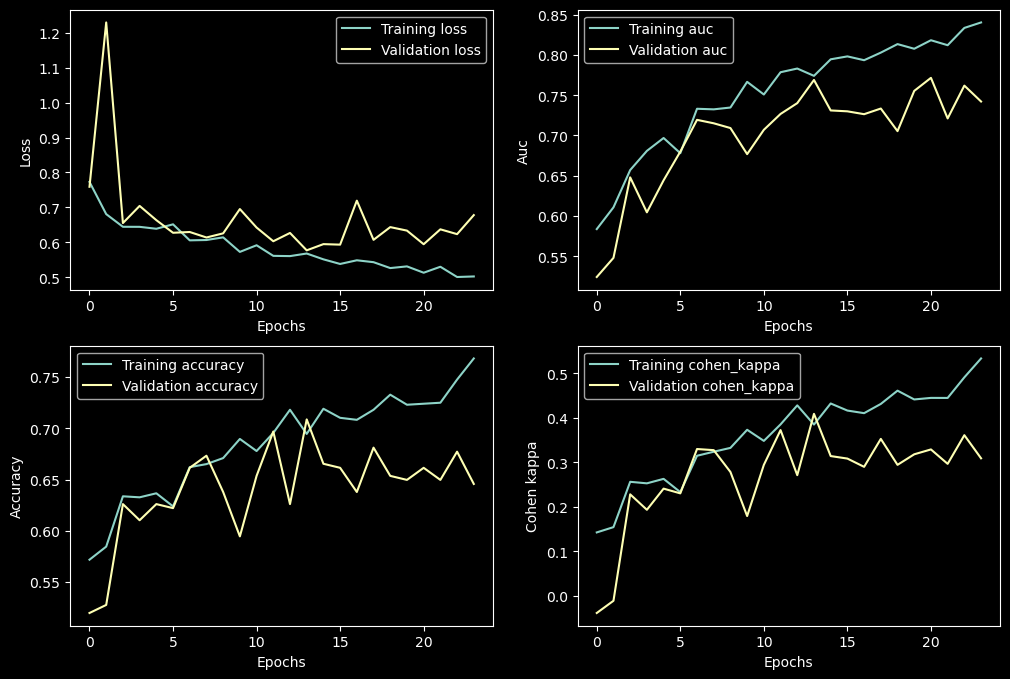

In [51]:
plot_all_metrics(history)


In [52]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_humerus.evaluate(validationset, verbose=1)

32/32 [==============================] - 3s 98ms/step - loss: 0.5789 - auc: 0.7584 - accuracy: 0.7047 - cohen_kappa: 0.4013 - f1_score: 0.6637


In [53]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.5789496898651123
accuracy    : 0.7584019899368286
auc         : 0.7047244310379028
cohen_kappa : 0.40128231048583984
f1_score    : 0.6636771559715271


#### XR_HAND

In [54]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=16,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4435 validated image filenames belonging to 2 classes.


In [55]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=16,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1108 validated image filenames belonging to 2 classes.


In [56]:
model_hand = make_cnn_model()

In [57]:
early_stop_hand = EarlyStopping(monitor="cohen_kappa", mode="min", patience=3, restore_best_weights=True)

In [58]:
history = model_hand.fit(
    trainset,
    epochs=10,
    validation_data=validationset,
    callbacks=[early_stop_hand]
)

Epoch 1/10
278/278 [==============================] - 72s 253ms/step - loss: 0.6212 - auc: 0.5557 - accuracy: 0.7215 - cohen_kappa: 0.0148 - f1_score: 0.0818 - val_loss: 0.6782 - val_auc: 0.4787 - val_accuracy: 0.6300 - val_cohen_kappa: -0.0472 - val_f1_score: 0.1700
Epoch 2/10
278/278 [==============================] - 69s 248ms/step - loss: 0.5715 - auc: 0.6032 - accuracy: 0.7339 - cohen_kappa: 4.1217e-04 - f1_score: 0.0084 - val_loss: 0.5990 - val_auc: 0.5783 - val_accuracy: 0.7175 - val_cohen_kappa: 0.0038 - val_f1_score: 0.0126
Epoch 3/10
278/278 [==============================] - 69s 249ms/step - loss: 0.5640 - auc: 0.6163 - accuracy: 0.7364 - cohen_kappa: 0.0164 - f1_score: 0.0315 - val_loss: 0.5779 - val_auc: 0.6330 - val_accuracy: 0.7175 - val_cohen_kappa: -0.0018 - val_f1_score: 0.0000e+00
Epoch 4/10
278/278 [==============================] - 68s 246ms/step - loss: 0.5507 - auc: 0.6501 - accuracy: 0.7362 - cohen_kappa: 0.0041 - f1_score: 0.0068 - val_loss: 0.5784 - val_auc: 0

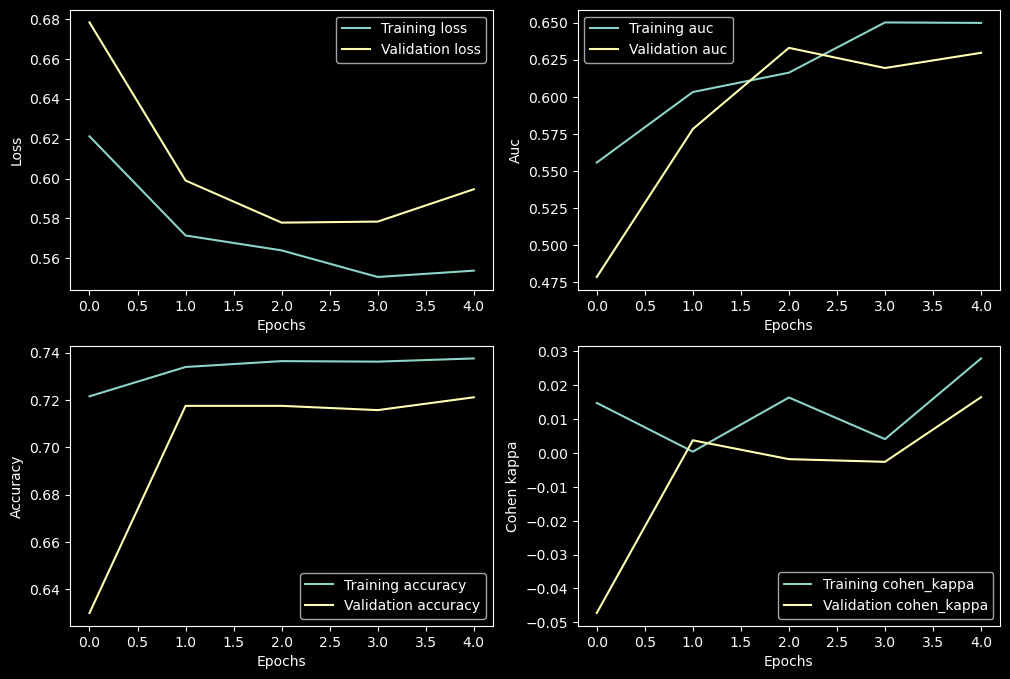

In [59]:
plot_all_metrics(history)

In [60]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_hand.evaluate(validationset, verbose=1)

70/70 [==============================] - 13s 189ms/step - loss: 0.5965 - auc: 0.5976 - accuracy: 0.7193 - cohen_kappa: 0.0074 - f1_score: 0.0127


In [61]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.5965434312820435
accuracy    : 0.5976396203041077
auc         : 0.7193140983581543
cohen_kappa : 0.007374405860900879
f1_score    : 0.012698412872850895


#### XR_WRIST

In [62]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 7802 validated image filenames belonging to 2 classes.


In [63]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1950 validated image filenames belonging to 2 classes.


In [64]:
model_wrist = make_cnn_model()

In [65]:
history = model_wrist.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/100
244/244 [==============================] - 122s 491ms/step - loss: 0.6824 - auc: 0.6173 - accuracy: 0.6048 - cohen_kappa: 0.1617 - f1_score: 0.4724 - val_loss: 0.7976 - val_auc: 0.5014 - val_accuracy: 0.5877 - val_cohen_kappa: 3.5328e-04 - val_f1_score: 0.1410
Epoch 2/100
244/244 [==============================] - 117s 478ms/step - loss: 0.6190 - auc: 0.6968 - accuracy: 0.6561 - cohen_kappa: 0.2786 - f1_score: 0.5586 - val_loss: 0.6266 - val_auc: 0.6812 - val_accuracy: 0.6467 - val_cohen_kappa: 0.2053 - val_f1_score: 0.4412
Epoch 3/100
244/244 [==============================] - 119s 486ms/step - loss: 0.5970 - auc: 0.7219 - accuracy: 0.6680 - cohen_kappa: 0.2972 - f1_score: 0.5600 - val_loss: 0.5753 - val_auc: 0.7485 - val_accuracy: 0.7000 - val_cohen_kappa: 0.3379 - val_f1_score: 0.5538
Epoch 4/100
244/244 [==============================] - 120s 493ms/step - loss: 0.5783 - auc: 0.7476 - accuracy: 0.6883 - cohen_kappa: 0.3414 - f1_score: 0.5899 - val_loss: 0.5776 - val_auc:

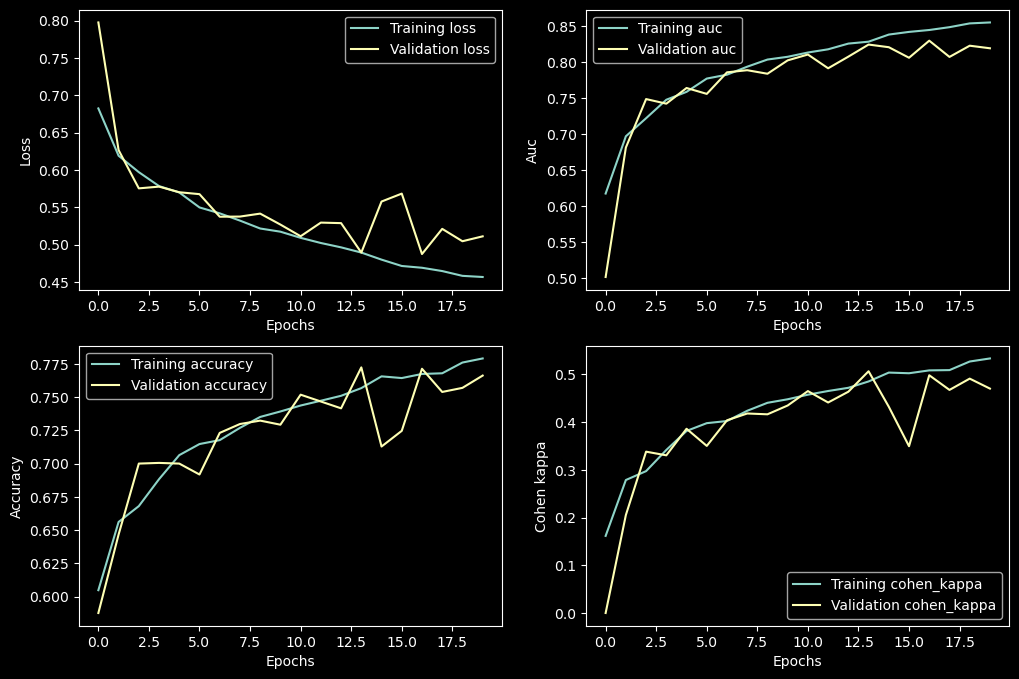

In [66]:
plot_all_metrics(history)

In [67]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_wrist.evaluate(validationset, verbose=1)

61/61 [==============================] - 26s 429ms/step - loss: 0.4794 - auc: 0.8373 - accuracy: 0.7779 - cohen_kappa: 0.5152 - f1_score: 0.6809


In [68]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.4794270396232605
accuracy    : 0.8372833132743835
auc         : 0.7779487371444702
cohen_kappa : 0.5152444839477539
f1_score    : 0.6809137463569641


#### XR_FOREARM

In [69]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=16,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1460 validated image filenames belonging to 2 classes.


In [70]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=16,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 365 validated image filenames belonging to 2 classes.


In [71]:
model_forearm = make_cnn_model()

In [72]:
history = model_forearm.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/100
92/92 [==============================] - 27s 275ms/step - loss: 0.7343 - auc: 0.5631 - accuracy: 0.5904 - cohen_kappa: 0.0692 - f1_score: 0.3611 - val_loss: 0.8430 - val_auc: 0.5917 - val_accuracy: 0.6603 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
92/92 [==============================] - 25s 272ms/step - loss: 0.6371 - auc: 0.6437 - accuracy: 0.6493 - cohen_kappa: 0.1371 - f1_score: 0.3173 - val_loss: 1.3841 - val_auc: 0.5164 - val_accuracy: 0.6603 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/100
92/92 [==============================] - 24s 264ms/step - loss: 0.6303 - auc: 0.6650 - accuracy: 0.6651 - cohen_kappa: 0.2011 - f1_score: 0.4044 - val_loss: 1.3308 - val_auc: 0.5608 - val_accuracy: 0.6575 - val_cohen_kappa: -0.0055 - val_f1_score: 0.0000e+00
Epoch 4/100
92/92 [==============================] - 24s 258ms/step - loss: 0.6151 - auc: 0.6691 - accuracy: 0.6664 - cohen_kappa: 0.2030 - f1_score: 0.4039 - val_loss: 0.7235 - val

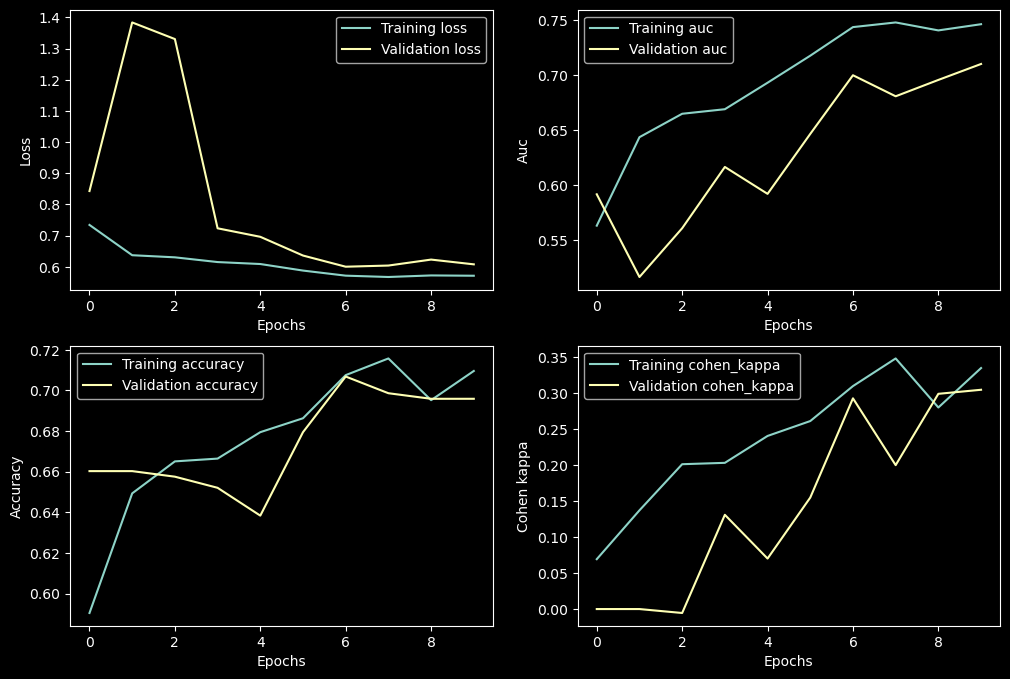

In [73]:
plot_all_metrics(history)

In [74]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_forearm.evaluate(validationset, verbose=1)

23/23 [==============================] - 5s 208ms/step - loss: 0.6069 - auc: 0.6920 - accuracy: 0.6986 - cohen_kappa: 0.2803 - f1_score: 0.4860


In [75]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6069469451904297
accuracy    : 0.6919924020767212
auc         : 0.698630154132843
cohen_kappa : 0.28033697605133057
f1_score    : 0.485981285572052


#### XR_FINGER

In [76]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4085 validated image filenames belonging to 2 classes.


In [77]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1021 validated image filenames belonging to 2 classes.


In [78]:
model_finger = make_cnn_model()

In [79]:
history = model_finger.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping]
)

Epoch 1/100
128/128 [==============================] - 71s 543ms/step - loss: 0.6395 - auc: 0.6766 - accuracy: 0.6472 - cohen_kappa: 0.2188 - f1_score: 0.4770 - val_loss: 0.8337 - val_auc: 0.6463 - val_accuracy: 0.3879 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.5589
Epoch 2/100
128/128 [==============================] - 65s 510ms/step - loss: 0.5921 - auc: 0.7157 - accuracy: 0.6617 - cohen_kappa: 0.2423 - f1_score: 0.4816 - val_loss: 0.6302 - val_auc: 0.6644 - val_accuracy: 0.6288 - val_cohen_kappa: 0.1494 - val_f1_score: 0.3857
Epoch 3/100
128/128 [==============================] - 64s 498ms/step - loss: 0.5773 - auc: 0.7351 - accuracy: 0.6752 - cohen_kappa: 0.2784 - f1_score: 0.5141 - val_loss: 0.6712 - val_auc: 0.5695 - val_accuracy: 0.6161 - val_cohen_kappa: 0.0310 - val_f1_score: 0.0968
Epoch 4/100
128/128 [==============================] - 64s 497ms/step - loss: 0.5633 - auc: 0.7596 - accuracy: 0.6984 - cohen_kappa: 0.3310 - f1_score: 0.5507 - val_loss: 0.5913 - val_auc: 0.7

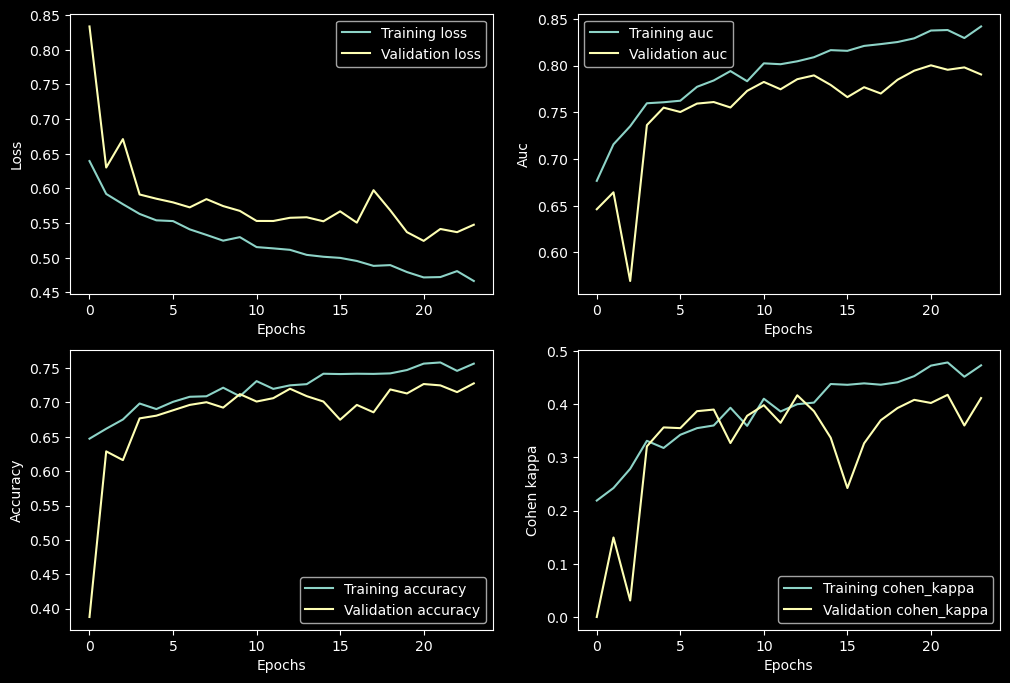

In [80]:
plot_all_metrics(history)

In [81]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model_finger.evaluate(validationset, verbose=1)

32/32 [==============================] - 13s 390ms/step - loss: 0.5406 - auc: 0.7885 - accuracy: 0.7091 - cohen_kappa: 0.3623 - f1_score: 0.5799


In [82]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.5406396985054016
accuracy    : 0.7885090708732605
auc         : 0.7091087102890015
cohen_kappa : 0.3623245358467102
f1_score    : 0.5799151659011841
